# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
#from torchvision.datasets import CIFAR-10 

# Define transforms
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               transforms.RandomHorizontalFlip(0.5),transforms.RandomCrop(size=32, padding=4)])
## DONE ##


# Create training set and define training dataloader
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
## DONE ##

# Create test set and define test dataloader
testset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)
## DONE ##

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 3, 32, 32])
torch.Size([64])


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [4]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(image.T)
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


truck


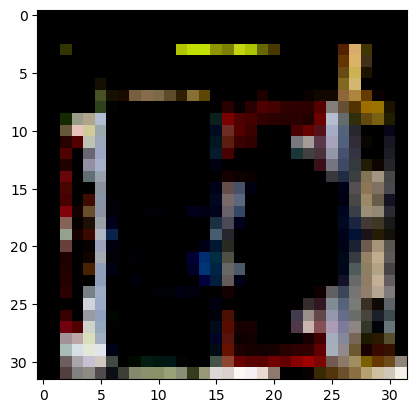

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


car


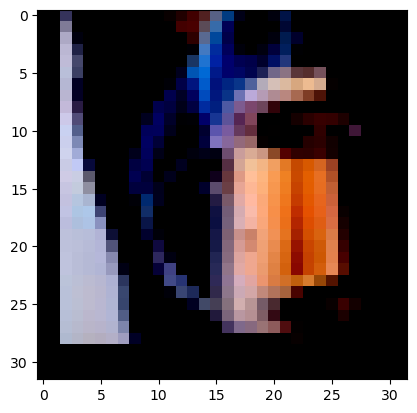

frog


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


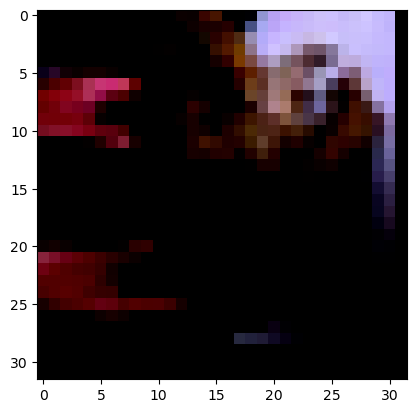

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


cat


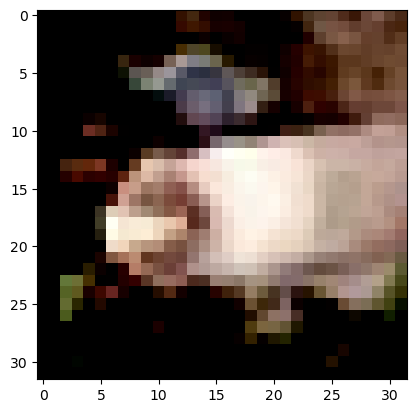

plane


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


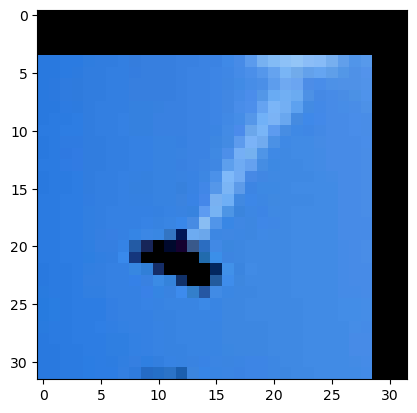

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


cat


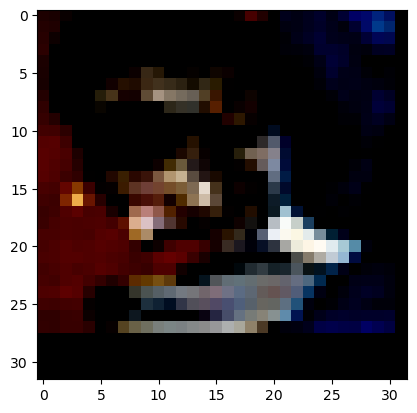

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ship


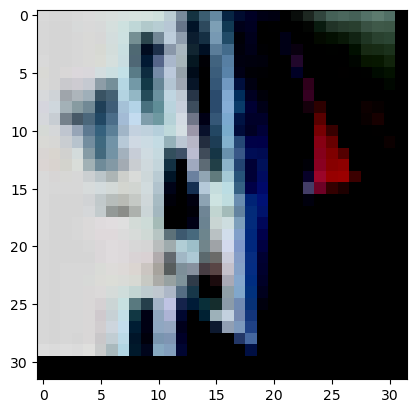

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ship


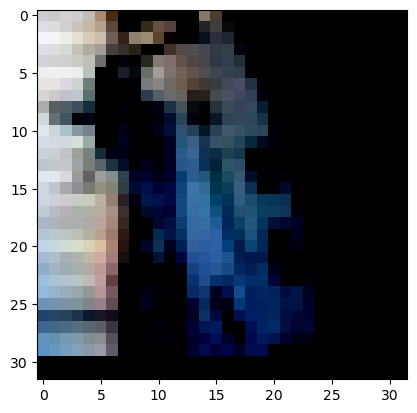

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plane


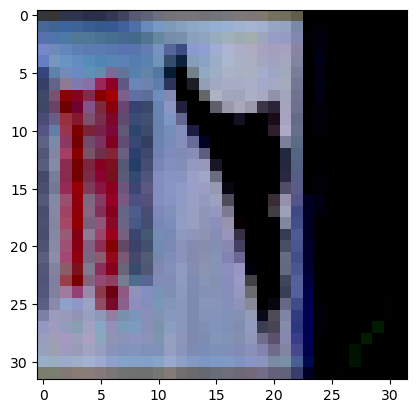

frog


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


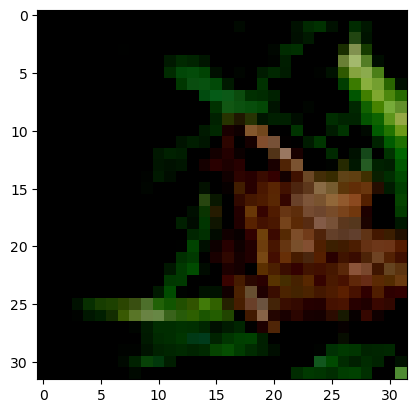

In [5]:
# Explore data
show5(trainloader)
show5(testloader)
## DONE ##

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class model(nn.Module):
    def __init__(self):
        super(model, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)
        
        # Batch normalization layers
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.pool(x)
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.pool(x)
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.pool(x)
        
        x = x.view(-1, 64 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.fc4(x)
        
        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [7]:
# Instantiate the model
model = model()

# define the loss function
criterion = nn.CrossEntropyLoss()

# optimizer with 0.01 learning rate
optimizer = optim.SGD(model.parameters(), lr=0.03)

print("Loss Function: Cross-Entropy Loss")
print("Optimizer: Stochastic Gradient Descent (SGD)")

#nn.CrossEntropyLoss() : is used as the loss function. Cross-Entropy Loss is commonly used for multi-class classification tasks like CIFAR-10.
#optim.SGD(net.parameters(), lr=0.001, momentum=0.9) : is used as the optimizer. SGD is a basic optimization algorithm used for training neural networks.

Loss Function: Cross-Entropy Loss
Optimizer: Stochastic Gradient Descent (SGD)


## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [8]:
import matplotlib.pyplot as plt

# Define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Move the network to the device
model.to(device)

# TODO: Train the network here
epochs = 75

train_losses = []  # Store the training losses

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Move data to the device if available
        images, labels = images.to(device), labels.to(device)
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        average_epoch_loss = running_loss / len(trainloader)
        train_losses.append(average_epoch_loss)
        print(f"Epoch [{e+1}/{epochs}], Training loss: {average_epoch_loss:.4f}")


Epoch [1/75], Training loss: 1.6667
Epoch [2/75], Training loss: 1.2707
Epoch [3/75], Training loss: 1.1095
Epoch [4/75], Training loss: 1.0068
Epoch [5/75], Training loss: 0.9420
Epoch [6/75], Training loss: 0.8888
Epoch [7/75], Training loss: 0.8396
Epoch [8/75], Training loss: 0.8055
Epoch [9/75], Training loss: 0.7784
Epoch [10/75], Training loss: 0.7466
Epoch [11/75], Training loss: 0.7255
Epoch [12/75], Training loss: 0.7076
Epoch [13/75], Training loss: 0.6890
Epoch [14/75], Training loss: 0.6721
Epoch [15/75], Training loss: 0.6601
Epoch [16/75], Training loss: 0.6417
Epoch [17/75], Training loss: 0.6317
Epoch [18/75], Training loss: 0.6169
Epoch [19/75], Training loss: 0.6122
Epoch [20/75], Training loss: 0.5997
Epoch [21/75], Training loss: 0.5901
Epoch [22/75], Training loss: 0.5759
Epoch [23/75], Training loss: 0.5650
Epoch [24/75], Training loss: 0.5650
Epoch [25/75], Training loss: 0.5517
Epoch [26/75], Training loss: 0.5497
Epoch [27/75], Training loss: 0.5338
Epoch [28/

Plot the training loss (and validation loss/accuracy, if recorded).

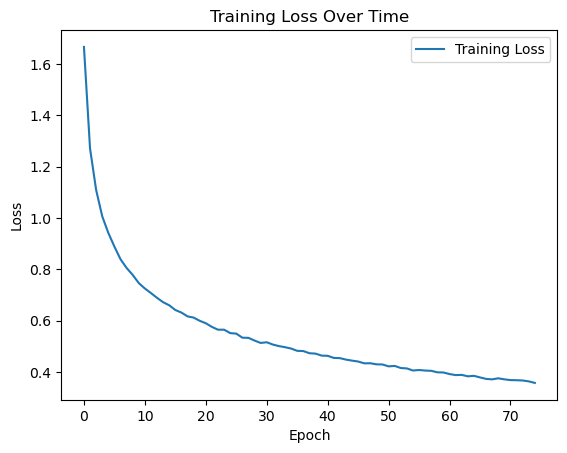

In [9]:

# Plot the training loss
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss Over Time')
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [10]:

# Put the model in evaluation mode
model.eval()

correct_test_predictions = 0
total_test_samples = 0

with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_test_samples += labels.size(0)
        correct_test_predictions += (predicted == labels).sum().item()

test_accuracy = (correct_test_predictions / total_test_samples) * 100

print(f"Test Accuracy: {test_accuracy:.2f}%")
## DONE ##

Test Accuracy: 82.54%


## Saving your model
Using `torch.save`, save your model for future loading.

In [12]:
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

Our model: 

 model(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
) 

The state dict keys: 

 odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'conv3

In [16]:
# Save the model's state_dict
torch.save(model.state_dict(), 'checkpoint.pth')

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.


**In my opinion, while building a neural network from scratch offers the advantage of complete customization and control over the model's architecture and training process, there are compelling reasons to consider a hybrid approach that involves both building and buying. Building a neural network might be a good choice if you possess a deep understanding of neural network concepts and wish to tailor the model to the specific intricacies of your task. However, considering the complexity and resource-intensive nature of training deep neural networks, I believe that incorporating pre-trained models into the process can be highly beneficial. By starting with a pre-trained model, you can harness the knowledge gained from large-scale training on similar problems, thus jump-starting your project. This hybrid strategy not only saves time and computational resources but also combines the best of both worlds – leveraging existing expertise while fine-tuning the model to suit your unique needs. As a result, I recommend pursuing an approach that combines the advantages of both building and buying, which could lead to more efficient and effective neural network development.**

